In [ ]:
#menginstall tensorflow & keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

#module yang dipakai
import numpy as np
import os
import sys

#image, plot, display, dan visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import IPython
from six.moves import urllib

print(tf.__version__)

2.6.0


In [ ]:
import tensorflow.compat.v1 as tf


Membuat model CNN classifier untuk mengklasifikasi gambar

In [ ]:
this_repo_url = 'https://github.com/lexfridman/mit-deep-learning/raw/master/'
this_tutorial_url = this_repo_url + 'tutorial_deep_learning_basics'


In [ ]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28 ,1)


In [ ]:
def preprocess_images(imgs):
  sample_img = imgs if len(imgs.shape) == 2 else imgs[0]
  assert sample_img.shape in [(28, 28, 1), (28, 28)], sample_img.shape
  return imgs/255.0

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

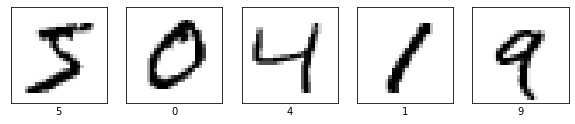

In [ ]:
plt.figure(figsize=(10,2))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i].reshape(28, 28), cmap=plt.cm.binary)
  plt.xlabel(train_labels[i])

In [35]:
model = keras.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


In [37]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
history = model.fit(train_images, train_labels, epochs=5)
print(test_images.shape)
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy : ',test_acc)

Epoch 1/5
1875/1875 [==============================] - 152s 81ms/step - loss: 0.4329 - accuracy: 0.8991
Epoch 2/5
1875/1875 [==============================] - 154s 82ms/step - loss: 0.1417 - accuracy: 0.9593
Epoch 3/5
1875/1875 [==============================] - 152s 81ms/step - loss: 0.1085 - accuracy: 0.9685
Epoch 4/5
1875/1875 [==============================] - 159s 85ms/step - loss: 0.0954 - accuracy: 0.9718
Epoch 5/5
1875/1875 [==============================] - 159s 85ms/step - loss: 0.0828 - accuracy: 0.9767
(10000, 28, 28, 1)
313/313 [==============================] - 6s 20ms/step - loss: 0.0503 - accuracy: 0.9861
Test accuracy :  0.9861000180244446


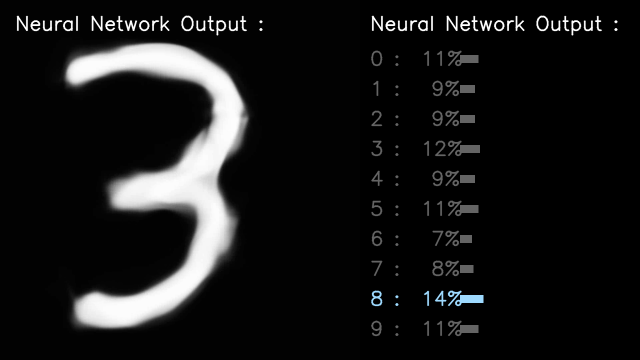

In [ ]:
mnist_dream_path = 'images/mnist_dream.mp4'
mnist_prediction_path = 'images/mnist_dream_predicted.mp4'

if not os.path.isfile(mnist_dream_path):
  print('downloading sample video ...')
  vid_url = this_tutorial_url + '/' + mnist_dream_path
  mnist_dream_path = urllib.request.urlretrieve(vid_url)[0]

def cv2_imshow(img):
  ret = cv2.imencode('.png', img)[1].tobytes()
  img_ip = IPython.display.Image(data=ret)
  IPython.display.display(img_ip)

cap = cv2.VideoCapture(mnist_dream_path)
vw = None
frame = -1

while True:
  frame += 1
  ret, img = cap.read()
  if not ret: break

  assert img.shape[0] == img.shape[1]
  if img.shape[0] != 720:
      img = cv2.resize(img, (720,720))

      img_proc = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      img_proc = cv2.resize(img_proc, (28, 28))
      img_proc = preprocess_images(img_proc)
      img_proc = 1 - img_proc
      net_in = np.expand_dims(img_proc, axis = 0)
      net_in = np.expand_dims(net_in, axis = 3)
      preds = model.predict(net_in)[0]
      guess = np.argmax(preds)
      perc = np.rint(preds * 100).astype(int)
      
      img = 255 - img
      pad_color = 0
      img = np.pad(img, ((0,0), (0,1280-720), (0,0)) , mode = 'constant' , constant_values = (pad_color))

      line_type = cv2.LINE_AA
      font_face = cv2.FONT_HERSHEY_SIMPLEX
      font_scale = 1.3
      thickness = 2
      x, y = 740, 60
      color = (255, 255, 255)

      text = "Output Jaringan Syaraf: "
      cv2.putText(img, text=text, org=(x,y) , fontScale=font_scale, fontFace = font_face, thickness=thickness,
                  color = color, lineType=line_type)
      
      txt = "Input : "
      cv2.putText(img, text=text, org=(30, y), fontScale=font_scale, fontFace=font_face, thickness=thickness,
                  color=color, lineType=line_type)
      
      y=130
      for i , p in enumerate(perc):
        if i == guess: color = (255, 218, 158)
        else: color = (100, 100, 100)

        rect_width = 0
        if p > 0: rect_width = int(p * 3.3)

        rect_start = 180
        cv2.rectangle(img, (x+rect_start, y-5), (x+rect_start+rect_width, y-20), color, -1)

        text = '{} : {:>3}%'.format(i, int(p))
        cv2.putText(img, text=text, org=(x,y), fontScale=font_scale, fontFace=font_face, thickness=thickness,
                    color = color, lineType=line_type)
        y += 60

        save_video = True

        if save_video:
          if vw is None:
            codec = cv2.VideoWriter_fourcc(*'DIVX')
            vid_width_height = img.shape[1], img.shape[0]
            vw = cv2.VideoWriter(mnist_prediction_path, codec, 30, vid_width_height)
            vw.write(img)
            vw.write(img)

      img_disp = cv2.resize(img, (0,0), fx=0.5, fy=0.5)
      cv2_imshow(img_disp)
      IPython.display.clear_output(wait=True)
  
cap.release()
if vw is not None:
    vw.releas()
